# Solar irradiance spectrum datasets tutorial

This tutorial illustrates how to:
- list available datasets
- visualise a dataset
- add your own solar irradiance spectrum.

<div class="alert alert-info">

This tutorial is available as a Jupyter notebook in the Eradiate codebase 
[`$ERADIATE_DIR/resources/data/notebooks/tutorials/solar_irradiance_datasets/solar_irradiance_datasets.ipynb`].

</div>

## List available datasets

Eradiate ships with a series of solar irradiance spectra datasets that serves as data inputs to the solar illumination components of the software. List the available datasets using:

In [1]:
import eradiate.data as data
display(data.registered(category="solar_irradiance_spectrum"))

['blackbody_sun',
 'meftah_2017',
 'thuillier_2003',
 'whi_2008',
 'whi_2008_1',
 'whi_2008_2',
 'whi_2008_3']

You can also consult the table in the [data.solar_irradiance_spectra](../../../rst/api_reference/generated/eradiate.data.solar_irradiance_spectra.rst#eradiate.data.solar_irradiance_spectra.rst) module documentation, which provides for each dataset the wavelength range and time range (when applicable) associated to the dataset, as well as a reference that describes the data or the methods used to produce it.

## Visualise a dataset

Visualise the solar irradiance spectrum using:

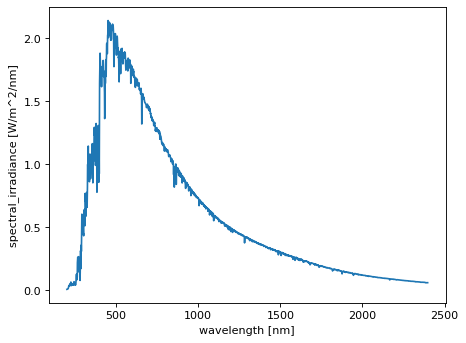

In [2]:
import eradiate.data as data
spectrum = data.open(category="solar_irradiance_spectrum", id="thuillier_2003")
spectrum.spectral_irradiance.plot()

## Use a custom solar irradiance spectrum dataset

<div class="alert alert-info">

This section is for advanced users.

</div>

Say you have a file called `my_data.csv` with your own solar irradiance data.
You would like to be able to use it within Eradiate.
For that, you need to convert this `csv` file into a `netcdf` file with the right format for Eradiate.
Here is how that can be achieved.
First, we read our data into a `DataFrame` object from the [pandas](https://pandas.pydata.org/) library:

In [3]:
import pandas as pd
df = pd.read_csv("my_data.csv", header=1, names=["w", "ssi"])

Next, we create a `Dataset` object with the values of wavelength and solar spectral irradiance that we have just read.
We create the data variable `ssi` (for solar spectral irradiance) with the dimension `w` (for wavelength) and the required metadata (including units).
The dataset must have two coordinates: `w` and `t` (for time) with corresponding metadata.
Our data does not include the time dimension so we just set the time coordinate to an empty array with 0 dimension.
Finally, set the attributes (`attrs`) of our dataset, including a nice title!
Refer to the
[CF-1.8 convention document](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.8/cf-conventions.html#description-of-file-contents)
for the meaning of these attributes.

In [4]:
import datetime
import numpy as np
import xarray as xr

ds = xr.Dataset(
    data_vars={
        "ssi": ("w", df.ssi.values, {
            "standard_name": "solar_irradiance_per_unit_wavelength",
            "long_name": "solar spectral irradiance",
            "units": "W/m^2/nm"})
    },
    coords={
        "w": ("w", df.w.values, {
            "standard_name": "wavelength",
            "long_name": "wavelength",
            "units": "nm"}),
        "t": ("t", np.empty(0), {
            "standard_name": "time",
            "long_name": "time"})
    },
    attrs={
        "title": "My awesome dataset!",
        "convention": "CF-1.8",
        "history": f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - data set creation - path/to/my_script.py",
        "source": "My custom observation data",
        "references": "My article, doi:10.1000/xyz123"
    }
)
display(ds)

<xarray.Dataset>
Dimensions:  (t: 0, w: 100)
Coordinates:
  * w        (w) float64 501.0 502.0 503.0 504.0 ... 597.0 598.0 599.0 600.0
  * t        (t) float64 
Data variables:
    ssi      (w) float64 0.5509 1.662 1.239 0.6718 ... 0.9626 1.32 0.9523 0.4564
Attributes:
    title:       My awesome dataset!
    convention:  CF-1.8
    history:     2020-12-11 10:14:00 - data set creation - path/to/my_script.py
    source:      My custom observation data
    references:  My article, doi:10.1000/xyz123

<div class="alert alert-info">

Eradiate solar irradiance spectrum datasets must follow a specific format defined by the `ssi_dataset_spec` variable in the [xarray](../../../rst/api_reference/generated/eradiate.util.xarray.rst) module.
    
</div>

In [5]:
from eradiate.util.xarray import ssi_dataset_spec

We can validate our dataset by running:

In [6]:
ds.ert.validate_metadata(ssi_dataset_spec)

A lazier way to define the dataset is to omit the `standard_name` and `long_name` metadata fields and **normalise** the dataset's metadata, which will add the missing fields:

In [7]:
ds = xr.Dataset(
    data_vars={
        "ssi": ("w", df.ssi.values, {"units": "W/m^2/nm"})},
    coords={
        "w": ("w", df.w.values, {"units": "nm"}),
        "t": ("t", np.empty(0))
    },
    attrs={
        "title": "My awesome dataset!",
        "convention": "CF-1.8",
        "history": f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - data set creation - path/to/my_script.py",
        "source": "My custom observation data",
        "references": "My article, doi:10.1000/xyz123"
    }
)
ds.ert.normalize_metadata(ssi_dataset_spec)
display(ds)

<xarray.Dataset>
Dimensions:  (t: 0, w: 100)
Coordinates:
  * w        (w) float64 501.0 502.0 503.0 504.0 ... 597.0 598.0 599.0 600.0
  * t        (t) float64 
Data variables:
    ssi      (w) float64 0.5509 1.662 1.239 0.6718 ... 0.9626 1.32 0.9523 0.4564
Attributes:
    title:       My awesome dataset!
    convention:  CF-1.8
    history:     2020-12-11 10:14:06 - data set creation - path/to/my_script.py
    source:      My custom observation data
    references:  My article, doi:10.1000/xyz123

This is not recommended but we could even have omitted the `units` field because our `ssi` and `w` have the same units as the default units in `ssi_dataset_spec`: 

In [8]:
display(ssi_dataset_spec.var_specs["ssi"].schema["units"])
display(ssi_dataset_spec.coord_specs["w"].schema["units"])

{'allowed': ['W/m^2/nm'], 'default': 'W/m^2/nm', 'required': True}

{'allowed': ['nm'], 'default': 'nm', 'required': True}